In [1]:
# Install packages first
!pip install tf-models-official==2.18.0
!pip install transformers==4.44.2
!pip install unidecode
import numpy as np 
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import mixed_precision
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModelForSequenceClassification
from official.nlp import optimization 

import re
from unidecode import unidecode
import os


print("Tensorflow version:",tf.__version__)
print(f"Transformers version: {transformers.__version__}")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 20.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.0/455.0 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 66.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 38.5 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

E0000 00:00:1756218347.123998      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230
/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensorflow version: 2.18.0
Transformers version: 4.44.2
/kaggle/input/hepsiburada-hackathon-kaggle-etabi/sample_submission.csv
/kaggle/input/hepsiburada-hackathon-kaggle-etabi/train.csv
/kaggle/input/hepsiburada-hackathon-kaggle-etabi/test.csv


In [2]:
adress_train = pd.read_csv("/kaggle/input/hepsiburada-hackathon-kaggle-etabi/train.csv")
adress_train.head()

,address,label
0,Akarca Mah. Adnan Menderes Cad. 864.Sok. No:15...,8831
1,Cumhuriye Mah. Hükümet Cad. Sivriler İşhanı No...,8810
2,İsmet inönü mahallesi 2001 sokak no:2 Çeşme be...,3067
3,"Gazeteci Hasan Tahsin Caddesi, No:10/3, Gizem...",8210
4,Bitez mahallesi Adnan Menderes caddesi gündonu...,9675


In [3]:
adress_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848237 entries, 0 to 848236
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  848237 non-null  object
 1   label    848237 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.9+ MB


In [4]:
# top 20 id count

In [5]:
# bottom 20 id count

In [6]:
def normalize_address(text):
    # handle turkish case before lower
    text = text.replace("İ", "i").replace("I", "ı")
    # Lowercase 
    text = text.lower()
    
    turkish_chars = "a-zşğüöçı"

    # Remove all punctuation except "-" and "/"
    text = re.sub(rf'[^\w\s\-\/{turkish_chars}]', ' ', text)

    # Remove excess whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # digit-text separation
    text = re.sub(rf'(\d+)([{turkish_chars}]+)', r'\1 \2', text)  # 122daire -> 122 daire
    text = re.sub(rf'([{turkish_chars}]+)(\d+)', r'\1 \2', text)  # daire12 -> daire 12
    
    # slash seperation
    text = re.sub(r'/',' / ', text)
    
    # hypen seperation
    text = re.sub(r'-',' - ', text)
    
    # Expand abbreviations
    text = re.sub(r'\bmah\.?\b', 'mahallesi', text)
    text = re.sub(r'\bmh\.?\b', 'mahallesi', text)
    text = re.sub(r'\bmahalle\.?\b', 'mahallesi', text)
    text = re.sub(r'\bmahallesı\.?\b', 'mahallesi', text)
    
    text = re.sub(r'\bcad\.?\b', 'caddesi', text)
    text = re.sub(r'\bcd\b', 'caddesi', text)  # Handle separated 'cd'
    text = re.sub(r'\bcadde\.?\b', 'caddesi', text)
    text = re.sub(r'\bcaddesı\.?\b', 'caddesi', text)

    text = re.sub(r'\bsok\.?\b', 'sokak', text)
    text = re.sub(r'\bsk\.?\b', 'sokak', text)
    text = re.sub(r'\sokağı\.?\b', 'sokak', text)
    text = re.sub(r'\sokaği\.?\b', 'sokak', text)
    
    text = re.sub(r'\bno\.?\b', 'numara', text)
    text = re.sub(r'\bnolu\.?\b', 'numara', text)
    text = re.sub(r'\bnum\.?\b', 'numara', text)
    
    text = re.sub(r'\bapt\.?\b', 'apartman', text)
    text = re.sub(r'\bapartmanı\.?\b', 'apartman', text)
    text = re.sub(r'\bapartmani\.?\b', 'apartman', text)
    text = re.sub(r'\bapart\.?\b', 'apartman', text)

    text = re.sub(r'\bdaıre\.?\b', 'daire', text)
    
    text = re.sub(r'\bblv\.?\b', 'bulvar', text)
    text = re.sub(r'\bbulv\.?\b', 'bulvar', text)
    
    text = re.sub(r'\btr\.?\b', 'türkiye', text)

    # Final space cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
def normalize_address(text):
    # handle turkish case before lower
    text = text.replace("İ", "i").replace("I", "ı")
    # Lowercase 
    text = text.lower()
    
    turkish_chars = "a-zşğüöçı"

    # Remove all punctuation except "-" and "/"
    text = re.sub(rf'[^0-9\s\-\/{turkish_chars}]', ' ', text)
    
    # digit-text separation
    text = re.sub(rf'(\d+)([{turkish_chars}]+)', r'\1 \2', text)  # 122daire -> 122 daire
    text = re.sub(rf'([{turkish_chars}]+)(\d+)', r'\1 \2', text)  # daire12 -> daire 12
    
    # slash seperation
    text = re.sub(r'/',' / ', text)
    
    # hypen seperation
    text = re.sub(r'-',' - ', text)
   
    # Expand abbreviations
    text = re.sub(r'\bmah\.?\b', 'mahallesi', text)
    text = re.sub(r'\bmh\.?\b', 'mahallesi', text)
    text = re.sub(r'\bmahalle\.?\b', 'mahallesi', text)
    text = re.sub(r'\bmahallesı\.?\b', 'mahallesi', text)
    
    text = re.sub(r'\bcad\.?\b', 'caddesi', text)
    text = re.sub(r'\bcd\b', 'caddesi', text)  # Handle separated 'cd'
    text = re.sub(r'\bcadde\.?\b', 'caddesi', text)
    text = re.sub(r'\bcaddesı\.?\b', 'caddesi', text)

    text = re.sub(r'\bsok\.?\b', 'sokak', text)
    text = re.sub(r'\bsk\.?\b', 'sokak', text)
    text = re.sub(r'\sokağı\.?\b', 'sokak', text)
    text = re.sub(r'\sokaği\.?\b', 'sokak', text)
    
    text = re.sub(r'\bno\.?\b', 'numara', text)
    text = re.sub(r'\bnolu\.?\b', 'numara', text)
    text = re.sub(r'\bnum\.?\b', 'numara', text)
    
    text = re.sub(r'\bapt\.?\b', 'apartman', text)
    text = re.sub(r'\bap\.?\b', 'apartman', text)
    text = re.sub(r'\bapartmanı\.?\b', 'apartman', text)
    text = re.sub(r'\bapartmani\.?\b', 'apartman', text)
    text = re.sub(r'\bapart\.?\b', 'apartman', text)

    text = re.sub(r'\bdaıre\.?\b', 'daire', text)

    # seperate daire and kat with number
    text = re.sub(r'\b(dair|dai|da|d)\s+(\d+)', r'daire \2', text)
    text = re.sub(r'\b(ka|k)\s+(\d+)', r'kat \2', text)
    
    text = re.sub(r'\bblv\.?\b', 'bulvar', text)
    text = re.sub(r'\btr\.?\b', 'türkiye', text)


    # Remove excess whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [8]:
# normalize address
adress_train["normalized_address"] = adress_train["address"].apply(normalize_address)

In [9]:
# count unique labels
classes = adress_train["label"].unique()
num_classes = len(classes)
print(num_classes)

10390


In [10]:
# Create label mapping
# it is necessary to have labels between 0 to num_classes - 1 for tensorlfow classification
label_to_idx = {label: idx for idx, label in enumerate(sorted(adress_train['label'].unique()))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Apply mapping
adress_train['original_label'] = adress_train['label']  # Keep original for reference
adress_train['label'] = adress_train['label'].map(label_to_idx)

In [11]:
# final address dataframe
display(adress_train.head(10))

,address,label,normalized_address,original_label
0,Akarca Mah. Adnan Menderes Cad. 864.Sok. No:15...,8830,akarca mahallesi adnan menderes caddesi 864 so...,8831
1,Cumhuriye Mah. Hükümet Cad. Sivriler İşhanı No...,8809,cumhuriye mahallesi hükümet caddesi sivriler i...,8810
2,İsmet inönü mahallesi 2001 sokak no:2 Çeşme be...,3066,ismet inönü mahallesi 2001 sokak numara 2 çeşm...,3067
3,"Gazeteci Hasan Tahsin Caddesi, No:10/3, Gizem...",8209,gazeteci hasan tahsin caddesi numara 10 / 3 gi...,8210
4,Bitez mahallesi Adnan Menderes caddesi gündonu...,9674,bitez mahallesi adnan menderes caddesi gündonu...,9675
5,Dedebaşı mahallesi 6100 sokak no 10 Kat 7 dair...,6377,dedebaşı mahallesi 6100 sokak numara 10 kat 7 ...,6378
6,Dikili Güzelbelde Sitesi Müsellim Altı No:51 K...,8667,dikili güzelbelde sitesi müsellim altı numara ...,8668
7,Yeni sanayi mahallesi 515 sokak no 53 c3 blok ...,1769,yeni sanayi mahallesi 515 sokak numara 53 c 3 ...,1770
8,Pazaryeri mah. 417. sk. No:6/4 Fethiye/MUĞLA,8907,pazaryeri mahallesi 417 sokak numara 6 / 4 fet...,8908
9,Gümüşlük mah. 5215 sok. D blok dış kapı no: 1 ...,9815,gümüşlük mahallesi 5215 sokak d blok dış kapı ...,9816


In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    adress_train["normalized_address"],
    adress_train["label"], 
    stratify= adress_train["label"],
    test_size=0.1, 
    random_state=42
)

In [13]:
model_name = "dbmdz/bert-base-turkish-128k-uncased"
# model_name = "dbmdz/electra-base-turkish-mc4-uncased-discriminator"

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
def prepare_dataset(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='tf'
    )
    
    dataset = tf.data.Dataset.from_tensor_slices({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })
    return dataset
    
train_dataset = prepare_dataset(x_train, y_train, tokenizer) 
val_dataset =  prepare_dataset(x_val, y_val, tokenizer)

I0000 00:00:1756218515.272969      10 service.cc:148] XLA service 0x56495de172e0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756218515.273021      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1756218515.273026      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1756218515.273029      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1756218515.273031      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1756218515.273034      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1756218515.273037      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1756218515.273040      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1756218515.273043      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


In [16]:
# Create distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')  # TPU detection
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [17]:
# Create model
epochs=12
batch_size=256

train_data_size = len(x_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)
# learning rate
init_lr = 3e-4


with strategy.scope():
    
    configuration = AutoConfig.from_pretrained(model_name, num_labels=num_classes)
    
    # set dropout rate to regularize the model
    # too high droputout rate on hidden and attention might worsen the performance 
    configuration.hidden_dropout_prob = 0.05
    configuration.attention_probs_dropout_prob = 0.05
    configuration.classifier_dropout = None
    
    classifier = TFAutoModelForSequenceClassification.from_pretrained(
        model_name, 
        configuration,
        num_labels=num_classes
    )
    optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw'
    )
    classifier.compile(
            optimizer=optimizer, 
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'] 
        )
    classifier.summary()


I0000 00:00:1756218534.928513      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  184345344 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  7989910   
                                                                 
Total params: 192335254 (733.70 MB)
Trainable params: 192335254 (733.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
shuffle_buffer_size = 10_000
batched_train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
batched_val_dataset = val_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [19]:
history = classifier.fit(
    batched_train_dataset,
    validation_data=batched_val_dataset,
    epochs=epochs
)

Epoch 1/12


I0000 00:00:1756218586.637688      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:10876151375733063315
E0000 00:00:1756218587.874438      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.
I0000 00:00:1756218590.072043    1097 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16937308252501573830), session_name()
I0000 00:00:1756218628.498225    1097 tpu_compile_op_common.cc:245] Compilation of 16937308252501573830 with session name  took 38.426095292s and succeeded
I0000 00:00:1756218628.619994    1097 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16937308252501573830), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_10876151375733063315", property.function_library_fingerprint = 10192652476140760585, property.mlir_module_fingerprint 

2982/2983 [============================>.] - ETA: 0s - loss: 0.7761 - accuracy: 0.0952

I0000 00:00:1756219067.810575    1057 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17716638243974593237), session_name()
I0000 00:00:1756219099.789851    1057 tpu_compile_op_common.cc:245] Compilation of 17716638243974593237 with session name  took 31.97923144s and succeeded
I0000 00:00:1756219099.880093    1057 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17716638243974593237), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_10876151375733063315", property.function_library_fingerprint = 10192652476140760585, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,70,;3,70,;3,;", property.guaranteed_constants_size = 0, embedding_par

2983/2983 [==============================] - ETA: 0s - loss: 0.7761 - accuracy: 0.0952

I0000 00:00:1756219105.505425      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9900567227162635247
E0000 00:00:1756219105.845815      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1756219106.567063    1098 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1087832596304861670), session_name()
I0000 00:00:1756219111.527334    1098 tpu_compile_op_common.cc:245] Compilation of 1087832596304861670 with session name  took 4.960224531s and succeeded
I0000 00:00:1756219111.550330    1098 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1087832596304861670), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_9900567227162635247", property.function_library_fingerprint = 12541597948836604066, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topolog

2983/2983 [==============================] - 574s 166ms/step - loss: 0.7761 - accuracy: 0.0952 - val_loss: 0.4140 - val_accuracy: 0.2295
Epoch 2/12
2983/2983 [==============================] - 449s 150ms/step - loss: 0.3344 - accuracy: 0.3420 - val_loss: 0.2703 - val_accuracy: 0.4419
Epoch 3/12
2983/2983 [==============================] - 449s 151ms/step - loss: 0.2354 - accuracy: 0.5019 - val_loss: 0.2227 - val_accuracy: 0.5364
Epoch 4/12
2983/2983 [==============================] - 449s 150ms/step - loss: 0.1842 - accuracy: 0.5989 - val_loss: 0.1975 - val_accuracy: 0.5944
Epoch 5/12
2983/2983 [==============================] - 448s 150ms/step - loss: 0.1477 - accuracy: 0.6717 - val_loss: 0.1795 - val_accuracy: 0.6385
Epoch 6/12
2983/2983 [==============================] - 448s 150ms/step - loss: 0.1188 - accuracy: 0.7328 - val_loss: 0.1684 - val_accuracy: 0.6680
Epoch 7/12
2983/2983 [==============================] - 447s 150ms/step - loss: 0.0949 - accuracy: 0.7846 - val_loss: 0.160

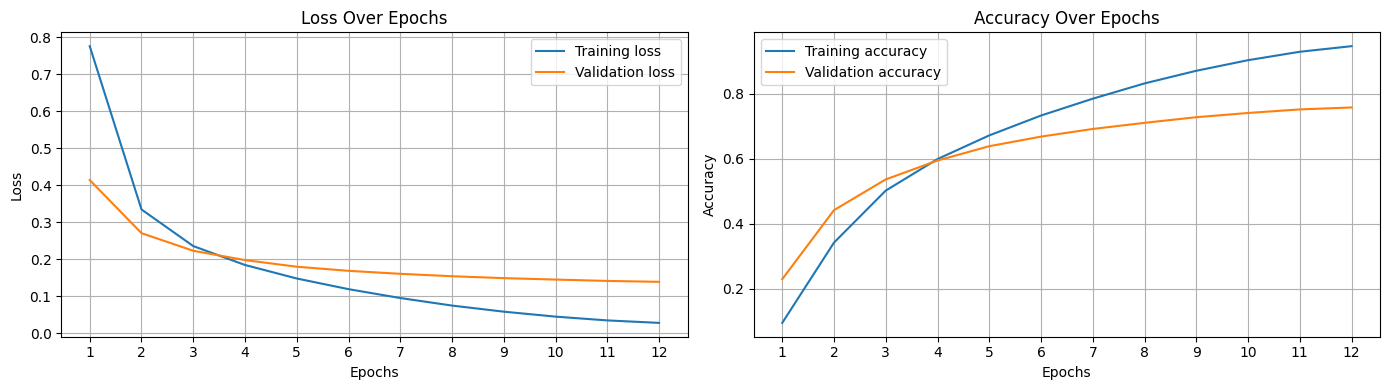

In [20]:
import matplotlib.pyplot as plt

# 'history' is the History object returned by model.fit()
history_dict = history.history

# Define the metrics to plot
metrics = ['loss', 'accuracy']

# Determine the number of metrics
num_metrics = len(metrics)

# Calculate the number of rows needed for 2 columns
num_rows = (num_metrics + 1) // 2

num_epochs = len(history_dict['loss'])
epoch_range = range(1, num_epochs + 1)

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
axes = axes.flatten()  # Flatten in case of a single row

# Plot each metric
for i, metric in enumerate(metrics):
    if metric in history_dict:
        axes[i].plot(epoch_range, history_dict[metric], label=f'Training {metric}')
    if f'val_{metric}' in history_dict:
        axes[i].plot(epoch_range, history_dict[f'val_{metric}'], label=f'Validation {metric}')
    axes[i].set_title(f'{metric.replace("_", " ").capitalize()} Over Epochs')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric.replace("_", " ").capitalize())
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_xticks(epoch_range)


# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
y_val_pred_prob = classifier.predict(batched_val_dataset)
y_val_pred = np.argmax(y_val_pred_prob.logits, axis=1)

I0000 00:00:1756224070.771488      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11274806636485217754
E0000 00:00:1756224071.065700      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1756224071.788457    1050 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10374729534357318159), session_name()
I0000 00:00:1756224077.098507    1050 tpu_compile_op_common.cc:245] Compilation of 10374729534357318159 with session name  took 5.309994558s and succeeded
I0000 00:00:1756224077.119242    1050 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10374729534357318159), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_11274806636485217754", property.function_library_fingerprint = 10612330873370607060, property.mlir_module_fingerprint = 0, property.num_replicas = 8,

331/332 [============================>.] - ETA: 0s

I0000 00:00:1756224087.708189    1089 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5694577650876427685), session_name()
I0000 00:00:1756224092.059565    1089 tpu_compile_op_common.cc:245] Compilation of 5694577650876427685 with session name  took 4.35133754s and succeeded
I0000 00:00:1756224092.085132    1089 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5694577650876427685), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_11274806636485217754", property.function_library_fingerprint = 10612330873370607060, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,56,;11,56,;11,;", property.guaranteed_constants_size = 0, embedding_pa

332/332 [==============================] - 25s 45ms/step


In [22]:
# Calculate F1 scores
f1_macro = f1_score(y_val, y_val_pred, average='macro')
f1_micro = f1_score(y_val, y_val_pred, average='micro')
f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")

F1 Score (macro): 0.7454
F1 Score (micro): 0.7575
F1 Score (weighted): 0.7535


In [23]:
adress_test = pd.read_csv("/kaggle/input/hepsiburada-hackathon-kaggle-etabi/test.csv")
adress_test.head()

,id,address
0,0,Menderes mahallesi 1013 sok No.40 Daire.2 Kat.2
1,1,250. Sk. No:14 B Blok Kat:5 Daire:14\n3. Halil...
2,2,Karahasanlı mah 2008 sok 800. Yıl konutları b2...
3,3,Barbaros mah. 4423 sokak no:1/6 Yunusemre Mani...
4,4,evka3 m şehitler c kardelen sitesi 10/3 didem ...


In [24]:
adress_test["normalized_address"] = adress_test["address"].apply(normalize_address)

In [25]:
def prepare_test_dataset(texts, tokenizer, max_length=128):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='tf'
    )
    
    dataset = tf.data.Dataset.from_tensor_slices({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    })
    return dataset
    
test_dataset = prepare_test_dataset(adress_test["normalized_address"], tokenizer) 

In [26]:
batched_test_dataset = test_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [27]:
y_test_pred_prob = classifier.predict(batched_test_dataset)
y_test_pred = np.argmax(y_test_pred_prob.logits, axis=1)

I0000 00:00:1756224130.952978      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15607028012000259988
E0000 00:00:1756224131.260334      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1756224131.936370    1108 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6833318092740810283), session_name()
I0000 00:00:1756224136.273614    1108 tpu_compile_op_common.cc:245] Compilation of 6833318092740810283 with session name  took 4.337205598s and succeeded
I0000 00:00:1756224136.293534    1108 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6833318092740810283), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15607028012000259988", property.function_library_fingerprint = 16510133170698130625, property.mlir_module_fingerprint = 0, property.num_replicas = 8, to

848/849 [============================>.] - ETA: 0s

I0000 00:00:1756224163.576614    1091 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7137044654269302051), session_name()
I0000 00:00:1756224167.764654    1091 tpu_compile_op_common.cc:245] Compilation of 7137044654269302051 with session name  took 4.187993746s and succeeded
I0000 00:00:1756224167.789562    1091 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7137044654269302051), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15607028012000259988", property.function_library_fingerprint = 16510133170698130625, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "20,72,;20,72,;", property.guaranteed_constants_size = 0, embedding_parti

849/849 [==============================] - 42s 37ms/step


In [28]:
# Convert predicted indices back to original labels using the idx_to_label mapping
y_test_pred_original = [idx_to_label[idx] for idx in y_test_pred]

# Create submission dataframe
submission = pd.DataFrame({
    'id': adress_test['id'],
    'label': y_test_pred_original
})

# Display first few predictions
print("predictions:")
print(submission.head())

predictions:
   id  label
0   0   4536
1   1   6068
2   2   1058
3   3   7853
4   4   6196


In [29]:
submission.to_csv("submission.csv", index=False)

In [30]:
# Save the entire model
classifier.save_pretrained("model/bert-base-turkish-address-128k-uncased")

# Also save the tokenizer
tokenizer.save_pretrained("tokenizer/bert-base-turkish-address-128k-uncased")

('tokenizer/bert-base-turkish-address-128k-uncased/tokenizer_config.json',
 'tokenizer/bert-base-turkish-address-128k-uncased/special_tokens_map.json',
 'tokenizer/bert-base-turkish-address-128k-uncased/vocab.txt',
 'tokenizer/bert-base-turkish-address-128k-uncased/added_tokens.json',
 'tokenizer/bert-base-turkish-address-128k-uncased/tokenizer.json')

In [31]:
# Save the label mappings
import json
i
# Force convert everything to standard Python types
with open("label_mappings.json", "w", encoding='utf-8') as f:
    json.dump({
        "label_to_idx": {str(k): int(v) for k, v in label_to_idx.items()},
        "idx_to_label": {str(k): str(v) for k, v in idx_to_label.items()},
        "num_classes": int(num_classes)
    }, f, ensure_ascii=False, indent=2)

In [32]:
def compute_probs_and_preds(classifier, tokenizer, texts, batch_size=256, max_length=128):
    """
    Compute probabilities and predictions for a list of texts using a Transformers classifier.
    """
    # Tokenize input - use the tokenizer's call method which returns all required inputs
    inputs = tokenizer(
        texts.tolist(), 
        padding=True, 
        truncation=True, 
        max_length=max_length, 
        return_tensors="tf"
    )
    
    # For Transformers models, use the model's __call__ method directly
    # This returns TFSequenceClassifierOutput
    outputs = classifier.predict(inputs, batch_size=batch_size)
    
    # Extract logits from the output object
    logits = outputs.logits
    
    # Convert to probabilities using softmax
    probs = tf.nn.softmax(logits, axis=1).numpy()
    preds_idx = probs.argmax(axis=1)
    pred_conf = probs.max(axis=1)
    
    return probs, preds_idx, pred_conf


In [33]:

def build_eval_dataframe(probs, preds_idx, pred_conf, x_val, y_val, adress_train, idx_to_label):

    # Ensure numpy arrays
    y_val_arr = np.array(y_val)
    val_indices = np.array(x_val.index)  # original dataset indices
    n = len(val_indices)
    assert probs.shape[0] == n, "probs length must match x_val length"
    
    df = pd.DataFrame({
        "val_position": np.arange(n),                     # position within validation slice
        "original_index": val_indices,                    # original row index in adress_train
        "normalized_address": x_val.values,               # cleaned/normalized text
        "true_label_idx": y_val_arr,
        "pred_label_idx": preds_idx,
        "pred_conf": pred_conf
    })
    # Map integer labels back to original label values (the label values you saved before mapping)
    df["true_label_original"] = df["true_label_idx"].map(lambda i: idx_to_label.get(int(i)))
    df["pred_label_original"] = df["pred_label_idx"].map(lambda i: idx_to_label.get(int(i)))
    # Fetch raw address and stored original_label from original dataframe by original_index
    df["original_address_raw"] = df["original_index"].map(lambda i: adress_train.loc[int(i), "address"])
    # If you stored the original label under 'original_label' column (as in your notebook), include it
    if "original_label" in adress_train.columns:
        df["true_label_original_from_df"] = df["original_index"].map(lambda i: adress_train.loc[int(i), "original_label"])
    return df


In [34]:

def get_confidence_splits(classifier, tokenizer, x_val, y_val, adress_train, idx_to_label,
                          batch_size=256, max_length=128, top_k=None):
    """
    Returns a tuple of three DataFrames:
      (correct_low_conf, incorrect_low_conf, incorrect_high_conf)
    Each DataFrame includes labels, normalized and original addresses, and pred_conf.
    - top_k: if set, returns only top_k rows for each DataFrame (useful for exporting/review).
    """
    probs, preds_idx, pred_conf = compute_probs_and_preds(classifier, tokenizer, x_val, batch_size=batch_size, max_length=max_length)
    results = build_eval_dataframe(probs, preds_idx, pred_conf, x_val, y_val, adress_train, idx_to_label)
    
    # correctness boolean
    results["is_correct"] = results["pred_label_idx"].astype(int) == results["true_label_idx"].astype(int)
    
    # correct with low confidence (ascending pred_conf)
    correct_low_conf = results[results["is_correct"]].sort_values("pred_conf", ascending=True).reset_index(drop=True)
    # incorrect with low confidence (ascending pred_conf)
    incorrect_low_conf = results[~results["is_correct"]].sort_values("pred_conf", ascending=True).reset_index(drop=True)
    # incorrect with high confidence (descending pred_conf)
    incorrect_high_conf = results[~results["is_correct"]].sort_values("pred_conf", ascending=False).reset_index(drop=True)
    
    # Optionally limit to top_k
    if top_k is not None:
        correct_low_conf = correct_low_conf.head(top_k)
        incorrect_low_conf = incorrect_low_conf.head(top_k)
        incorrect_high_conf = incorrect_high_conf.head(top_k)
    
    # Reorder / pick columns to show side-by-side original + normalized + labels + confidence
    cols = ["original_index", "original_address_raw", "normalized_address",
            "true_label_idx", "true_label_original", 
            "pred_label_idx", "pred_label_original", "pred_conf"]
    # keep safe: if some columns don't exist, filter them
    cols = [c for c in cols if c in correct_low_conf.columns]
    return correct_low_conf[cols], incorrect_low_conf[cols], incorrect_high_conf[cols]


In [35]:

correct_low_conf, incorrect_low_conf, incorrect_high_conf = get_confidence_splits(
     classifier=classifier,
     tokenizer=tokenizer,
     x_val=x_val,
     y_val=y_val,
     adress_train=adress_train,
     idx_to_label=idx_to_label,
     batch_size=256,
     max_length=128,
     top_k=1000  # optional: only take top 200 per split
 )
# # Save to CSV
correct_low_conf.to_csv("correct_low_conf.csv", index=False)
incorrect_low_conf.to_csv("incorrect_low_conf.csv", index=False)
incorrect_high_conf.to_csv("incorrect_high_conf.csv", index=False)

I0000 00:00:1756224185.022078      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14071206965932647378
I0000 00:00:1756224186.048875    1052 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6126133708628278144), session_name()
I0000 00:00:1756224190.964127    1052 tpu_compile_op_common.cc:245] Compilation of 6126133708628278144 with session name  took 4.915214754s and succeeded
I0000 00:00:1756224190.984538    1052 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6126133708628278144), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_14071206965932647378", property.function_library_fingerprint = 1944002347714504108, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z

331/332 [============================>.] - ETA: 0s

I0000 00:00:1756224201.379195    1040 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13348458930668787811), session_name()
I0000 00:00:1756224205.705418    1040 tpu_compile_op_common.cc:245] Compilation of 13348458930668787811 with session name  took 4.326176601s and succeeded
I0000 00:00:1756224205.732574    1040 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13348458930668787811), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_14071206965932647378", property.function_library_fingerprint = 1944002347714504108, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,56,;11,56,;11,56,;", property.guaranteed_constants_size = 0, embedd

332/332 [==============================] - 25s 44ms/step


In [36]:
print("Correct but low confidence (top 20):")
display(correct_low_conf.head(20))

Correct but low confidence (top 20):


,original_index,original_address_raw,normalized_address,true_label_idx,true_label_original,pred_label_idx,pred_label_original,pred_conf
0,275491,YIGIT SOK. MOR EVLER SITESI. NO:6 D:3,yıgıt sokak mor evler sıtesı numara 6 daire 3,1485,1486,1485,1486,0.053214
1,173015,208 sokak no 10/4 Rumali mahzen İzmir Selçuk,208 sokak numara 10 / 4 rumali mahzen izmir se...,1946,1947,1946,1947,0.068838
2,681759,Yıldırım Sok. No:4A Kat:1 D:1,yıldırım sokak numara 4 a kat 1 daire 1,1742,1743,1742,1743,0.079131
3,265124,Ertuğrul Gazi Cad No 145C Villaport Sitesi C2 ...,ertuğrul gazi caddesi numara 145 c villaport s...,9172,9173,9172,9173,0.082625
4,114460,Kanarya Sok. No:32 Yeni Elmas Sitesi B Blok Da...,kanarya sokak numara 32 yeni elmas sitesi b bl...,2617,2618,2617,2618,0.086531
5,91543,129 sok. no:74/1,129 sokak numara 74 / 1,1883,1884,1883,1884,0.094353
6,292153,Adatepe Mah. 2/14 Sol No 10 D. 2 İzmir Buca,adatepe mahallesi 2 / 14 sol numara 10 daire 2...,4023,4024,4023,4024,0.094813
7,23056,Mithatpaşa Caddesi no 34 (palmiye oto yıkamaya...,mithatpaşa caddesi numara 34 palmiye oto yıkam...,4136,4137,4136,4137,0.097928
8,319606,Gülenç Sk. cafer tombul apartmanı no7 daire:3 ...,gülenç sokak cafer tombul apartman numara 7 da...,1653,1654,1653,1654,0.098211
9,756657,Prof. Hikmet Şimşek sokak no:5,prof hikmet şimşek sokak numara 5,3799,3800,3799,3800,0.102110


In [37]:
print("Incorrect and low confidence (top 20):")
display(incorrect_low_conf.head(20))

Incorrect and low confidence (top 20):


,original_index,original_address_raw,normalized_address,true_label_idx,true_label_original,pred_label_idx,pred_label_original,pred_conf
0,692353,Askeri caddesi no 20 yeni gençlik sitesi B blo...,askeri caddesi numara 20 yeni gençlik sitesi b...,6207,6208,1853,1854,0.035385
1,171267,K.KIRHAN. SK.NO:3/1,k kırhan sokak numara 3 / 1,1668,1669,9840,9841,0.041572
2,501517,2118. Sokak Göksu Evleri No:3,2118 sokak göksu evleri numara 3,3350,3351,2892,2893,0.042553
3,16860,Mimarsinan cad no 18 balin cam,mimarsinan caddesi numara 18 balin cam,766,767,2623,2624,0.044585
4,217024,Ümran Şen Sk. Serbest Muhasebeci Mali Müşavir ...,ümran şen sokak serbest muhasebeci mali müşavi...,9494,9495,7136,7137,0.045854
5,613223,FETIH CAD. NO 68 MERT SITESI A BLOK KAT 1 DAIR...,fetıh caddesi numara 68 mert sıtesı a blok kat...,6904,6905,8861,8862,0.046217
6,93131,Sehitkubilay sokak çiğdem apt no 22 kat 1 dair...,sehitkubilay sokak çiğdem apartman numara 22 k...,4062,4063,2603,2604,0.047965
7,653318,Çeşmetepe Mahallesi İnönü Caddesi No: 98,çeşmetepe mahallesi inönü caddesi numara 98,1204,1205,8523,8524,0.048158
8,218312,"Yağmur evleri apartmanı, A blok, Kat:6,Daire:24",yağmur evleri apartman a blok kat 6 daire 24,5388,5389,8670,8671,0.048753
9,126752,Müftü yakup ones cad no.3 gurup otel altı,müftü yakup ones caddesi numara 3 gurup otel altı,9702,9703,9268,9269,0.050438


In [38]:
print("Incorrect but high confidence (top 20):")
display(incorrect_high_conf.head(20))

Incorrect but high confidence (top 20):


,original_index,original_address_raw,normalized_address,true_label_idx,true_label_original,pred_label_idx,pred_label_original,pred_conf
0,343176,6474 SK No 5/1 Kat 1 Daire 2 Doğa Apartmanı YA...,6474 sokak numara 5 / 1 kat 1 daire 2 doğa apa...,6270,6271,6269,6270,0.999814
1,23851,Aksaz sk.No:38/10,aksaz sokak numara 38 / 10,9304,9305,9813,9814,0.999705
2,400253,AKARCALI MH HACI ALİEFENDİ CD NO 346\n\nAkarca...,akarcalı mahallesi hacı aliefendi caddesi numa...,5125,5126,5124,5125,0.999633
3,631701,Camikebir Mahallesi Çetinkaya Sokak No:17 Kat:...,camikebir mahallesi çetinkaya sokak numara 17 ...,1738,1739,1742,1743,0.999607
4,198959,Yeşilüzümlü mahallesi 520 yeni sok no. 16 Fethiye,yeşilüzümlü mahallesi 520 yeni sokak numara 16...,8986,8987,9101,9102,0.999556
5,691803,Konacık Mahallesi Gazi Kara Abdullah Sokak BC ...,konacık mahallesi gazi kara abdullah sokak bc ...,9660,9661,9841,9842,0.999526
6,718307,Bostanlı Mahallesi 2022 sokak No:13 Bostanlı P...,bostanlı mahallesi 2022 sokak numara 13 bostan...,7137,7138,5841,5842,0.999510
7,762966,1.sokak 87/A hakan et dikili bademli hakan et ...,1 sokak 87 / a hakan et dikili bademli hakan e...,8497,8498,8474,8475,0.999486
8,303472,2. Sanayi sitesi Karayolları 2. Bölge Müdürlüğ...,2 sanayi sitesi karayolları 2 bölge müdürlüğü ...,5488,5489,5709,5710,0.999465
9,314064,Zorlar mahallesi yeni mahalle sokak no:116 sey...,zorlar mahallesi yeni mahallesi sokak numara 1...,9016,9017,8950,8951,0.999436
